In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime

In [28]:
def save_df_to_csv(saved_df, tag):
    # Save csv of the data
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Timestamp for the file name
    saved_df.to_csv(f'./training_data/data_tb_labeled/LOG_{now}_{tag}.csv', index=False)
    print(f"Values of LOG saved to ./training_data/LOG_{now}_{tag}.csv")

In [9]:
def filter_successive_ids(input_csv):
    """
    This function takes a csv of pressure values as input and filters the successive values that have the same id.

    Parameters:
    input_csv: string containing the path to a csv containing duplicate values of id 

    Returns:
    df (pd.DataFrame): DataFrame containing the filtered values with columns 'id, timestamp, pressure_values'
    """
    with open(input_csv, mode='r') as infile, open('./LOG_CROPPED.csv', mode='w', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        
        buffer = []
        
        for row in reader:
            buffer.append(row)
            # Only keep the last three rows in the buffer
            if len(buffer) > 3:
                buffer.pop(0)
            
            # Check if the buffer contains the sequence [1, 2, 3]
            if len(buffer) == 3:
                    if [r['id'] for r in buffer] == ['1', '2', '3']:
                        for b_row in buffer:
                            writer.writerow(b_row)
                        buffer = []
    
    return pd.read_csv('./LOG_CROPPED.csv')

In [17]:
def pressure_to_elevation_m(pressure_Pa):
    """
    This function takes a pressure_values and converts it to an elevation value using the atmospheric formula.

    Parameters:
    pressure_Pa: integer of a pressure value.

    Returns:
    h_cm: integer of an elevation value in cm
    """
    pressure_hPa = pressure_Pa / 100
    # Constants
    P0 = 1013.25  # sea level standard atmospheric pressure in hPa
    L = 0.0065    # temperature lapse rate in K/m
    T0 = 288.15   # sea level standard temperature in K
    g = 9.80665   # acceleration due to gravity in m/s^2
    M = 0.0289644 # molar mass of Earth's air in kg/mol
    R = 8.31432   # universal gas constant in N·m/(mol·K)

    # Calculate the exponent
    exponent = (R * L) / (g * M)
    
    # Calculate the height in meters
    h_m = (T0 / L) * (1 - (pressure_hPa / P0) ** exponent)
    
    # Convert the height to centimeters
    h_cm = h_m * 100
    
    return int(h_cm)
    # return int(h_m)

In [11]:
def preprocess_df_pressure(in_csv):
    out_data = filter_successive_ids(in_csv)
       
    # Preprocessing the data before plotting
    out_data.astype(int)
    
    # subtract from the reading of device 3. Measurement correction done after calibration.
    correction = 19
    out_data.loc[out_data['id'] == 3, 'pressure_values'] -= correction
    
    # Subtract from pressure value at sea level
    out_data['pressure_values'] = 101325 - out_data['pressure_values']
    
    return out_data

In [14]:
def preprocess_df_elevation(in_csv):
    # out_data = filter_successive_ids(in_csv)
    out_data = pd.read_csv(in_csv)
    # Preprocessing the data before plotting
    out_data.astype(int)
    
    # subtract from the reading of device 3. Measurement correction done after calibration.
    # correction = 19 
    # out_data.loc[out_data['id'] == 3, 'pressure_values'] -= correction
    out_data['elevation_value'] = out_data['pressure_values'].apply(pressure_to_elevation_m)
    out_data = out_data.drop(columns=['pressure_values'])
   
    return out_data



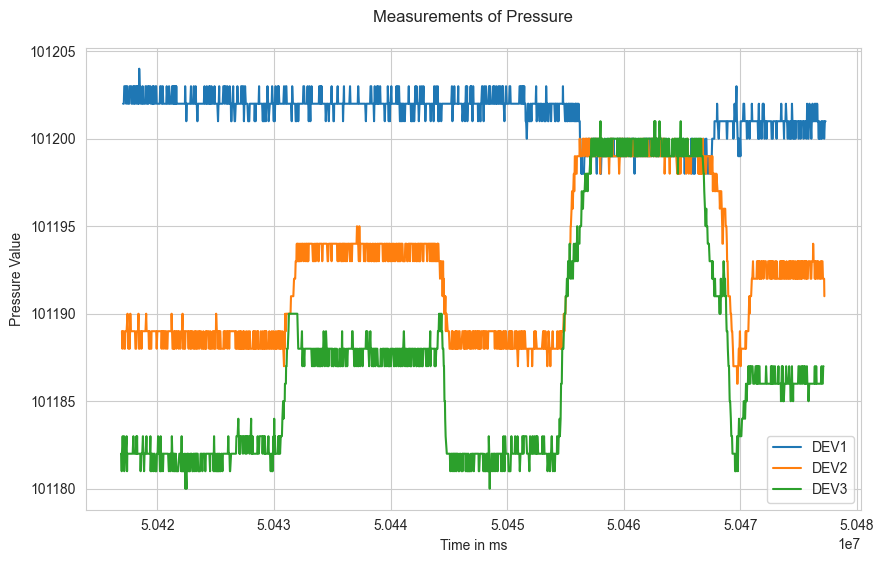

In [12]:
def plot_pressure_data(plot_df):
    """
    This function takes a DataFrame of pressure values as input and plots the values.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'id, timestamp, pressure_values'

    Returns:
    None
    """
    # Plot data for each id
    unique_ids = plot_df['id'].unique()
    plt.figure(figsize=(10, 6), dpi=100)
    for unique_id in unique_ids:
        subset = plot_df[plot_df['id'] == unique_id]
        plt.plot(subset['timestamp'], subset['pressure_values'], label=f'DEV{unique_id}')

    # Plot the elevation Data
    plt.title(f'Measurements of Pressure\n')
    plt.ylabel("Pressure Value")
    plt.xlabel("Time in ms")
    plt.legend(loc="lower right")
    plt.show()


pressure_df = pd.read_csv('./Measurements_01/LOG_2024-07-25_14-01_standsitstandlaysit.csv')
plot_pressure_data(pressure_df)

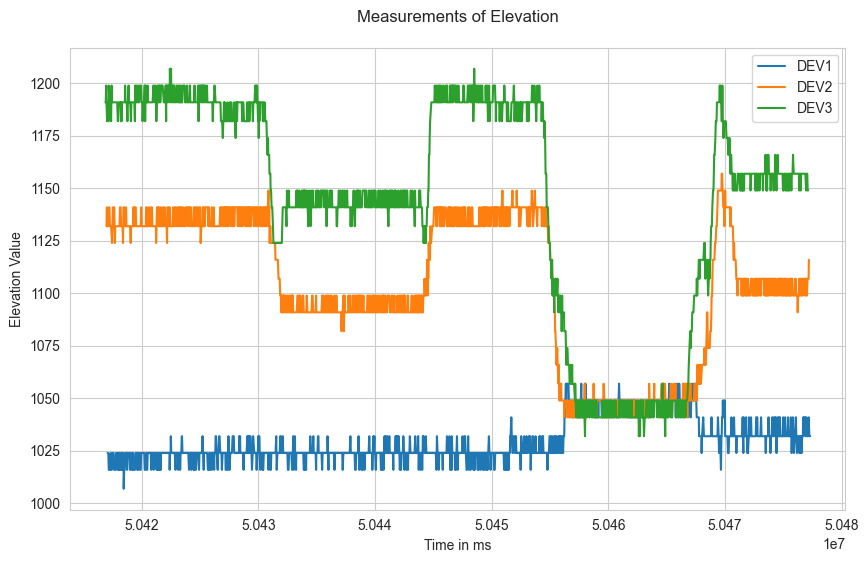

In [21]:
def plot_elevation_data(plot_df):
    """
    This function takes a DataFrame of elevation values as input and plots the values.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'id, timestamp, elevation_value'

    Returns:
    None
    """
    # Plot data for each id
    unique_ids = plot_df['id'].unique()
    plt.figure(figsize=(10, 6), dpi=100)

    for unique_id in unique_ids:
        subset = plot_df[plot_df['id'] == unique_id]
        plt.plot(subset['timestamp'], subset['elevation_value'], label=f'DEV{unique_id}')

    # Plot the elevation Data
    plt.title(f'Measurements of Elevation\n')
    plt.ylabel("Elevation Value")
    plt.xlabel("Time in ms")
    plt.legend(loc="upper right")
    plt.show()
    
elevation_df = preprocess_df_elevation('./Measurements_01/LOG_2024-07-25_14-01_standsitstandlaysit.csv')
plot_elevation_data(elevation_df)

In [23]:
def calculate_deltas_elevation(data_frame):
    """
    This function takes a DataFrame of elevation values with header 'id, timestamp, elevation_value' as input,
    calculates the difference in elevation and returns a new Df with an index and delta values.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'id, timestamp, elevation_value'

    Returns:
    df (pd.DataFrame): DataFrame containing columns 'index, delta3_1 , delta3_2, delta2_1'
    """
    results = []
    for i in range(len(data_frame) - 2):
        subset = data_frame.iloc[i:i + 3]
        if subset['id'].nunique() == 3:
            # Calculate the differences between their elevation values
            elevation_value = subset.set_index('id')['elevation_value']
            delta3_1 = elevation_value[3] - elevation_value[1]
            delta3_2 = elevation_value[3] - elevation_value[2]
            delta2_1 = elevation_value[2] - elevation_value[1]

            # Append the result
            results.append([i, delta3_1, delta3_2, delta2_1])
    
    # Convert the results to a DataFrame
    deltas_df = pd.DataFrame(results, columns=['index', 'delta3_1', 'delta3_2', 'delta2_1'])

    return deltas_df



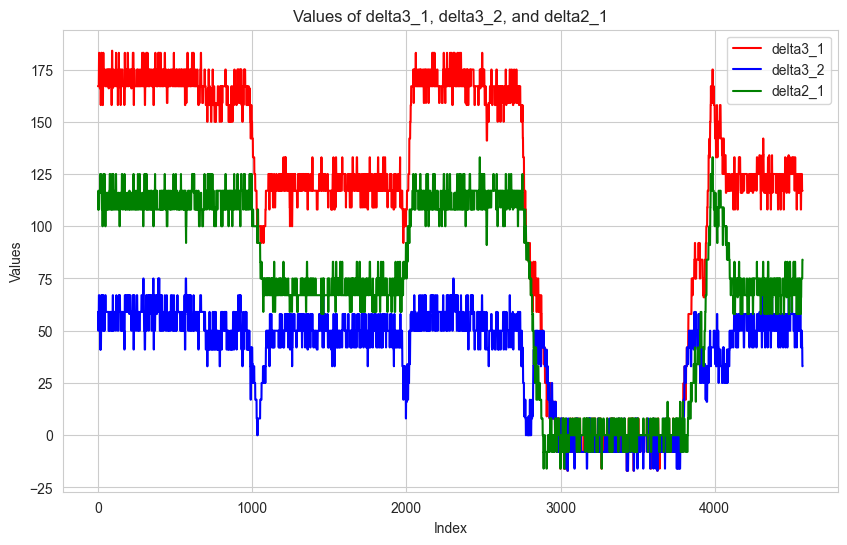

In [25]:
def plot_deltas(deltas_df):
    """
    This function takes a DataFrame of elevation deltas as input and plots the values.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'index', 'delta3_1', 'delta3_2', and 'delta2_1'

    Returns:
    None
    """
    # Set 'index' column as the index for plotting
    deltas_df.set_index('index', inplace=True)

    # Plot each column
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(deltas_df.index, deltas_df['delta3_1'], label='delta3_1', color='r')
    plt.plot(deltas_df.index, deltas_df['delta3_2'], label='delta3_2', color='b')
    plt.plot(deltas_df.index, deltas_df['delta2_1'], label='delta2_1', color='g')

    plt.title('Values of delta3_1, delta3_2, and delta2_1')
    plt.xlabel('Index')
    plt.ylabel('Values')

    plt.legend()
    plt.grid(True)
    plt.show()


elevation_df = preprocess_df_elevation('./Measurements_01/LOG_2024-07-25_14-01_standsitstandlaysit.csv')
deltas_df = calculate_deltas_elevation(elevation_df)
plot_deltas(deltas_df)


In [30]:
def label_based_on_timestamp(elevation_delta_df, time_ranges):
    """
    Label DataFrames and save the labeled data to a csv in a specific folder.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'index', 'delta3_1', 'delta3_2', and 'delta2_1'
    time_ranges (Dict): Time ranges associated with an activity label.
    
    Output:
    None
    """
    elevation_delta_df['label'] = 'undefined'
    
    # Iterate over the ranges and apply labels
    for start, end, label in time_ranges:
        elevation_delta_df.loc[(elevation_delta_df['index'] >= start) & (elevation_delta_df['index'] <= end), 'label'] = label
    
    return elevation_delta_df

# Pre-process data
df_elevation = preprocess_df_elevation('training_data/Measurements_01/LOG_2024-07-25_14-09_laystandsitstand.csv')
# display(df_elevation.head())

# Calculate deltas
deltas_elevation = calculate_deltas_elevation(df_elevation)
# display(deltas_elevation)

# Define timestamp ranges and their corresponding labels
ranges = [
    (0, 148, 'sit_lay'),
    (149, 1185, 'lay'),
    (1186, 1457, 'lay_stand'),
    (1458, 1867, 'stand'),
    (1868, 2046, 'stand_sit'),
    (2047, 2876, 'sit'),
    (2877, 3004, 'sit_stand'),
    (3005, 4236, 'stand'),
]

# Label the DataFrame
labeled_df = label_based_on_timestamp(deltas_elevation, ranges)
display(labeled_df)

# Save labeled Data
save_df_to_csv(labeled_df, "lay_stand_sit_stand")

,index,delta3_1,delta3_2,delta2_1,label
0,0,83,8,75,sit_lay
1,1,75,8,67,sit_lay
2,2,75,16,59,sit_lay
3,3,67,8,59,sit_lay
4,4,75,8,67,sit_lay
...,...,...,...,...,...
4232,4232,167,67,100,stand
4233,4233,167,67,100,stand
4234,4234,167,67,100,stand
4235,4235,167,58,109,stand


Values of LOG saved to ./training_data/LOG_2024-09-02_23-05-44_lay_stand_sit_stand.csv


In [26]:
'''
Label Data
'''
# Pre-process data
df_elevation = preprocess_df_elevation('training_data/Measurements_01/LOG_2024-07-25_14-09_laystandsitstand.csv')
# display(df_elevation.head())

# Calculate deltas
deltas_elevation = calculate_deltas_elevation(df_elevation)
# display(deltas_elevation)

# Define timestamp ranges and their corresponding labels
ranges = [
    (0, 148, 'sit_lay'),
    (149, 1185, 'lay'),
    (1186, 1457, 'lay_stand'),
    (1458, 1867, 'stand'),
    (1868, 2046, 'stand_sit'),
    (2047, 2876, 'sit'),
    (2877, 3004, 'sit_stand'),
    (3005, 4236, 'stand'),
]

# Label the DataFrame
labeled_df = label_based_on_timestamp(deltas_elevation, ranges)

# Display the labeled DataFrame
display(labeled_df)

# Save labeled Data
save_df_to_csv(labeled_df, "lay_stand_sit_stand")


NameError: name 'label_based_on_timestamp' is not defined

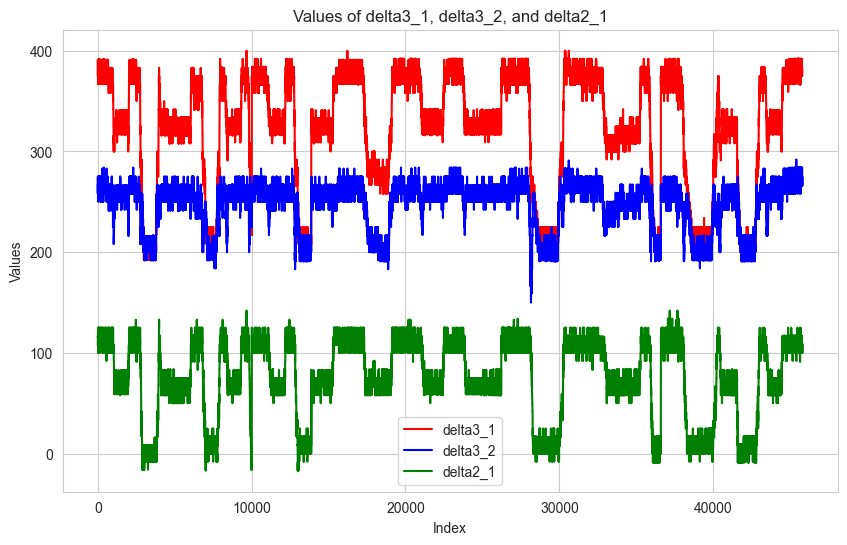

In [18]:
# df_elevation = preprocess_df_elevation('training_data/Measurements_01/LOG_2024-07-25_14-01_standsitstandlaysit.csv')
df_deltas = pd.read_csv('training_data/combined_training_data_01.csv')

# display(df_elevation.head())

# Calculate deltas
# deltas_elevation = calculate_deltas_elevation(df_elevation)
# display(deltas_elevation.head())

plot_deltas(df_deltas)
# plot_elevation_data(df_elevation)

# Label Data (tbd)

# Save labeled Data
# save_df_to_csv(deltas_elevation, "stand_sit_stand_lay_sit")

# Plot labeled data
# plot_pressure_data(data_pressure)


In [176]:
import pandas as pd
import glob
import os

def append_csvs_to_single_csv(input_folder, output_csv):
    """
    Appends multiple CSV files from a specified folder into a single CSV file.

    Parameters:
    input_folder (str): The folder containing the CSV files to be appended.
    output_csv (str): The path to the output CSV file.
    
    Output:
    None
    """
    # Get a list of all CSV files in the input folder
    csv_files = glob.glob(os.path.join(input_folder, '*.csv'))
    
    # Initialize an empty list to hold the DataFrames
    dataframes = []
    
    # Loop through the list of CSV files and read each into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        dataframes.append(df)
    
    # Concatenate all DataFrames into a single DataFrame
    combined_training_df = pd.concat(dataframes, ignore_index=True)
    
    # reset the index. 
    combined_training_df['index'] = range(len(combined_training_df))
    # Write the combined DataFrame to a single CSV file
    combined_training_df.to_csv(output_csv, index=False)
    print(f'Combined CSV file has been saved to {output_csv}')


append_csvs_to_single_csv('training_data/data_tb_labeled', 'training_data/combined_training_data_01.csv')


Combined CSV file has been saved to training_data/combined_training_data_01.csv


<class 'pandas.core.series.Series'>


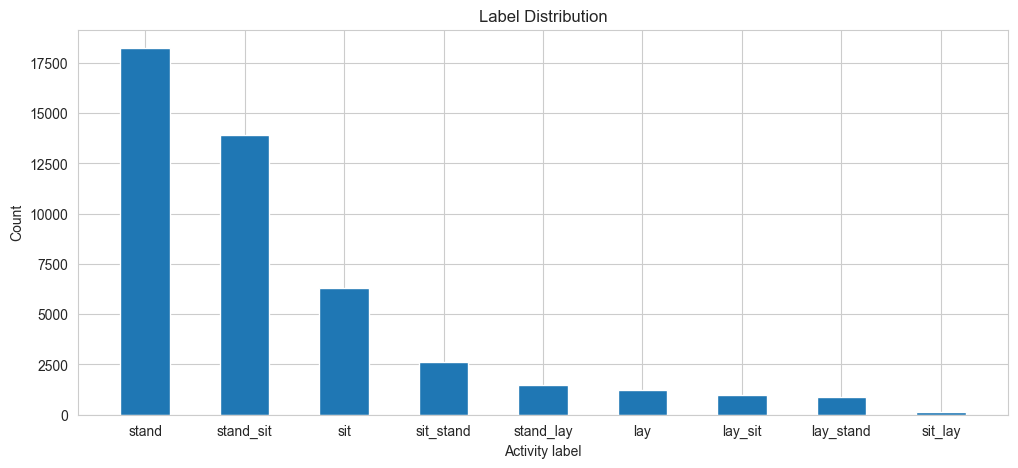

In [33]:
# Analyse the labeling
combined_df = pd.read_csv('training_data/combined_training_data_01.csv')
# plot_deltas(combined_df)

unique_labels = combined_df['label'].unique()
# print(unique_labels)

value_counts_labels = combined_df['label'].value_counts()
print(value_counts_labels)

# plot the label counts over all activities, using x and y axes:
def plot_stats(labels, label_count):
  plt.figure(figsize=(12, 5))
  plt.bar(labels, label_count, width=0.5)
  plt.xlabel('Activity label')
  plt.ylabel('Count')
  plt.title('Label Distribution')
  plt.show()

# use the above function to display the activity label counts:
#  the x_axis parameter should hold the label strings ('running', etc.),
#  the y_axis parameter should hold their counts
plot_stats(unique_labels, value_counts_labels)



label
stand        18248
sit          13928
lay           6308
stand_lay     2603
stand_sit     1493
sit_stand     1226
lay_stand      961
lay_sit        876
sit_lay        149
Name: count, dtype: int64


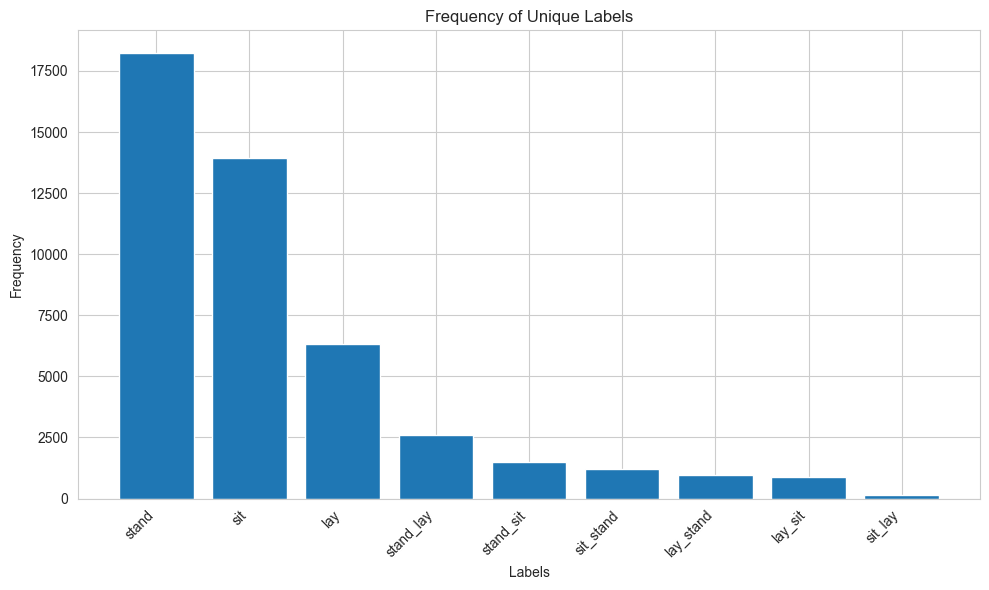

In [38]:
combined_df = pd.read_csv('training_data/combined_training_data_01.csv')

# Get the unique labels and their frequencies
unique_labels = combined_df['label'].unique()
label_counts = combined_df['label'].value_counts()

def plot_stats(label_count):
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(label_count.index, label_count.values)
    
    # Adding titles and labels
    plt.title('Frequency of Unique Labels')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    
print(label_counts)
plot_stats(label_counts)
